# Pandas Introduction Part II  Pivot and Merge

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gawron/python-for-social-science/blob/master/pandas/general_pandas_intro.ipynb)

In [9]:
# Import all libraries needed for the tutorial

##import (library) as (give the library a nickname/alias)
import numpy as np
import pandas as pd  
# General syntax to import specific functions in a library: 
##from (library) import (specific library function)
from pandas import DataFrame, read_csv

# The usual preamble when using matplotlib. 
# Most of the code we call is in pyplot.
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
#pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

## Loading Data

The next cell loads data from my website and will take some time to execute.  
It is slow because
it is retrieving a number of large uncompressed files containing year
by year babynames data,

In [1]:
import pandas as pd
years = list(range(1880,2011))
pieces = []
columns = ['name','sex','births']

url = 'https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/names/'
for year in years:
    path = f'{url}yob{year:d}.txt'
    frame = pd.read_csv(path,names=columns)
    frame['year'] = year
    pieces.append(frame)    
    
names = pd.concat(pieces, ignore_index=True)

## Pivot tables

### Introducing the pivot table

Suppose, as an aid to interpreting the numbers in the `'births'` column, we we are interest in the average popularity of a female name.  Then we want to find the mean births for all female names. 

We might proceed as follows. Pick a year, say 1881.

In [12]:
names1881 = names[names['year']  == 1881]

In [494]:
namesfemale1881 = names1881[names1881['sex'] == 'F']
namesfemale1881['births'].mean()

98.03304904051173

We might characterize this code as follows:

2. **Split step**: Line 1  **splits off** a group of rows, `namesfemale1881` using one of the possible values in `sex` column.  We'll call that column the **indexing** column.
3. **Apply step**: Line 2 **applies**  an **aggregation function**  ( `.mean()` ) to the `'births'` column of those rows; call `births` the **values** column.


In this example we performed the **split** step on one of
the possible values in the indexing column, then performed **apply step**
on one group of rows.
As we saw with cross-tabulation. we  frequently want to perform these two steps for all possible values in the
indexing column.  

And of course that leads to the need for combining: we want to **combine** the results in a new
Data Structure, indexed by the values that defined our groups  In our example,
the indexing column is `'sex'` with possible values `'F'` and `'M`', so
we'd like a new DataFrame with a single column containing the `'births'` means for those groups.

Summarizing: we need to **split** the DataFrame into groups of rows  (using an index column),
**apply** (applying an aggregation function to a values column), and **combine** (into a DataFrame).
These are exactly the steps we executed for cross-tabulation.  The difference
in this case is that instead of just counting the groups of rows, we want to
apply the aggregation function to the *values* column `'births'` .
It turns out this variation on the three steps comes up often  enough to merit a name.

All three steps can be performed using **pivot table** method.

In [13]:
pt = names1881.pivot_table(values= 'births',index='sex',aggfunc='mean')

In [14]:
pt

,births
sex,
F,98.033049
M,101.051153


In fact, `mean` is the default aggregation function, and the first and second
arguments of the `.pivot_table()` method are always the values column and the index
column, so we get the same result by writing:

In [15]:
pt = names1881.pivot_table('births','sex')
pt

,births
sex,
F,98.033049
M,101.051153


It is worth emphasizing the importance of the **combine** step;
the `.pivot_table()` method combines its results into
a **DataFrame**. That means we can leverage all our knowledge
of how DataFrames work in using it, for example, by plotting the results.  One of the key takeaways about `pandas`
is that almost all the functions and methods that apply to DataFrames and Series
return either a DataFrame or a Series.  By understanding
the properties of what's returned, we can use it more effectively in
the next analytical step.

As desired, the values in the `'sex'` column now index the new DataFrame:

In [16]:
pt.index

Index(['F', 'M'], dtype='object', name='sex')

Note the original name of the indexing column has been preserved,
as the above output shows. It is stored in the `name` attribute 
of the DataFrame index:

In [321]:
pt.index.name

'sex'

As with any DataFrame, `.loc[ ]`  is used to access individual rows using names
from the index.

In [498]:
# Any expression containing this is a KeyError
# pt['sex']
# because 'sex' is not the name of a column in `pt`.
pt.loc['F']

births    98.033049
Name: F, dtype: float64

We have just found the **mean** female and male births for 1881.

Suppose we want **total births** instead of mean births.  It can still be done 
with a pivot table, and we still need to group by sex, and apply an aggregation functiomn to the values
column, but we need to change our **aggregation function** from `mean` to `sum`.

In [22]:
names1881.pivot_table('births','sex',aggfunc='sum')

,births
sex,
F,91955
M,100748


So now we know the total number of male and female births in 1881 (at least
those accounted for our data sample).

Continuing along these lines, let's move back to the `names` DataFrame:
Suppose we want to find birth totals by gender and by year. That is,  we want a new DataFrame in which the index
value for a row is a year 
and the two columns show the total births for `'F'` and `'M'` in that year.  

So want the following **pivot table**:

In [17]:
total_births = names.pivot_table('births','year', columns='sex', aggfunc='sum')


In [23]:
total_births.head()

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445


Of course we could just as easily have the index values be genders and the columns be years.

In [6]:
total_births2 = names.pivot_table('births','sex', columns='year', aggfunc='sum')
#only showing the first 10 of 131 columns
total_births2.iloc[:,:10]

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889
sex,,,,,,,,,,
F,90993,91955,107851,112322,129021,133056,144538,145983,178631,178369
M,110493,100748,113687,104632,114445,107802,110785,101412,120857,110590


The difference between these two pivot table computations lies entirely
in the combine step.

Under the hood both DataFrames require computing the same row groups and applying `'sum'` to the `births` column in each group.

In fact, `total_births2` is the transpose of `total_births`.

In [621]:
import numpy as np
np.all(total_births2.T == total_births)

True

Thus in `total_births`, we find the 2006 birth totals with `.loc[]`:

In [55]:
total_births.loc[2006]

sex
F    1896468
M    2050234
Name: 2006, dtype: int64

In `total_births2`, we access the  same 2006 birth totals the way we access any column.

In [25]:
total_births2[2006]

sex
F    1896468
M    2050234
Name: 2006, dtype: int64

Since `total_births` and `total_births2` contain essentially the same information,
let's summarize what we learned about the `.pivot_table()` method with
`total_births`.

How was `total_births` created?  By three steps

1. Splitting the rows of `name` into groups  (one for each year, gender pair).
2. Applying the aggregation function `sum` to each group
3. Combining the results into a single DataFrame `total_births`.

This is the now familiar the split/apply/combine strategy.  

#### Cross tab versus pivot_table

Compare `total_births2` with the output of `pd.crosstab`, which we use to get the joint distribution counts for two attributes; although the rows and columns are the same, the 
numbers are different.

In [4]:
total_births2.iloc[:,:5]

year,1880,1881,1882,1883,1884
sex,,,,,
F,90993,91955,107851,112322,129021
M,110493,100748,113687,104632,114445


In [7]:
crosstab_sex_year = pd.crosstab(names['sex'],names['year'])
crosstab_sex_year.iloc[:,:10]

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889
sex,,,,,,,,,,
F,942,938,1028,1054,1172,1197,1282,1306,1474,1479
M,1058,997,1099,1030,1125,1097,1110,1067,1177,1111


In [512]:
crosstab_sex_year[1880]['F']

942

What does 

```
crosstab_sex_year[1880]['F']
```

mean?

It represents how many times the `names` DataFrame 
pairs 1880 in the `'year'` column with 'F' in
the `'sex'` column, and in `names`, that amounts to computing how many
distinct female names there were in 1880.  

In this example `pd.crosstab` combined two columns of the `names` DataFrame
to  compute the crosstab DataFrame `crosstab_sex_year`.
In general, `pd.crosstab` takes any two sequences of equal length and
computes how many times unique pairings  occur.  

```
[1,0,1,0,0,1,1]
[b,b,b,a,b,a,a]
```
For example, in the two arrays seen here, a `1` from the first sequence is paired with a `b` from the second twice.  The results are summarized in the cross-tabulation DataFrame. 

In [508]:
pd.crosstab(np.array([1,0,1,0,0,1,1]),np.array(['b','b','b','a','b','a','a']))

col_0,a,b
row_0,,
0,1,2
1,2,2


If the two sequences are columns from a DataFrame, then the counts tell us how many
rows contain each possible pairing of values.  So each pair of values defines
a group of rows (the rows with `'year'` 1881 and `'sex'` 'F', for example, in `names`).
Note there's no values column
providing numbers to perform an aggregation operation on.  All we do is
compute the row groups and count their sizes.

Now there is one curve ball, mentioned here because you may
come across code that uses it: `pd.crosstab` has an optional `values` argument.
In lieu of just counting the rows in a group,  we can apply an aggregation operation to the 
values column of the row groups.

For example we can use `crosstab` to
recreate `total_births2`, the DataFrame we created
above with `pivot_table`.  Here is the DataFrame we created with `pivot_table`.

In [8]:
total_births2.iloc[:,:10]

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889
sex,,,,,,,,,,
F,90993,91955,107851,112322,129021,133056,144538,145983,178631,178369
M,110493,100748,113687,104632,114445,107802,110785,101412,120857,110590


And here is the same DataFrame using `crosstab`.

In [9]:
# Specify sum as the aggregation function
# and births as the numerical value column for sum to apply to
ct_table = pd.crosstab(names['sex'],names['year'], values= names['births'],aggfunc='sum')
ct_table.iloc[:,:10]

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889
sex,,,,,,,,,,
F,90993,91955,107851,112322,129021,133056,144538,145983,178631,178369
M,110493,100748,113687,104632,114445,107802,110785,101412,120857,110590


So it is possible to use `crosstab` to create a
`pivot_table` type DataFrame; however, the general convention
is that it is clearer to use `pivot_table`, the more specific tool, to
create what most people know as a pivot table.

## Plotting

All data frames have a `plot` method; for
a simple DataFrame like a pivot table
the the `plot` method draws a very simple picture. 

Consider plotting `total_births`, the pivot table created in a previous
section.  Here's the DataFrame.  Note the index and the two columns:

In [ ]:
total_births

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445
...,...,...
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310


And here is the default plot, which puts the index on the x-axis and plots the two columns
as separate line plots.

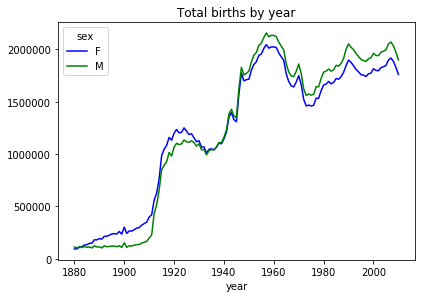

In [ ]:
from matplotlib import pyplot as plt
ax = total_births.plot(title='Total births by year') 
#plt.show()

## Alternative plotting script

The above graph is great and often what we want is just to take a quick look at the relationships in the data, and the default DataFrame plot will do exactly the right thing with no customization.  It's helpful to know that `pandas` is using a Python package called `matplotlib` to draw the graph above, and we can do the same ourselves, with a lot more lines of code, but also with a lot more customization.

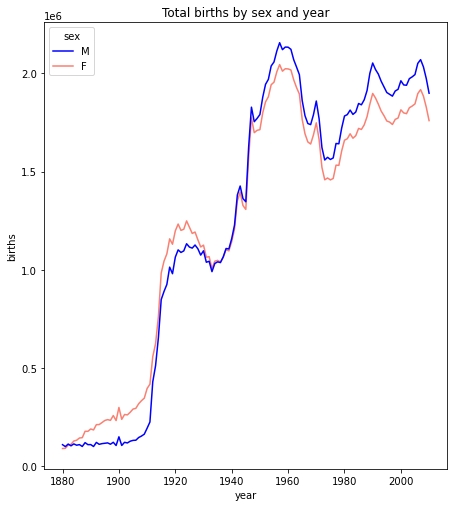

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(1,figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.subplots_adjust(top=0.9,left=0.2)
ax1.set_ylabel('births')

ax1.set_xlabel('year')
(p1,) = ax1.plot(total_births.index,total_births['F'],color='salmon',label='F')
(p2, ) = ax1.plot(total_births.index,total_births['M'],color='blue',label='M')
ax1.set_title('Total births by sex and year')
    
ax1.legend((p2,p1),('M','F'),loc='upper left',title='sex')
plt.show()

The basic requirement for the `matplotlib.plot(...)` function 
is that you need to supply two sequences of the same length giving the x- and y- 
coordinates respectively of the plot. We can optionally specify plot attributes like line
style, color, and label (for use in the legend) for each line plotted. 

There are also other plot functions which could provide alternative views of the 
relationships.

For example, we could do this as a bar plot. The focus below is on lines 9 and 10 which draw
the bar plots for the two genders.

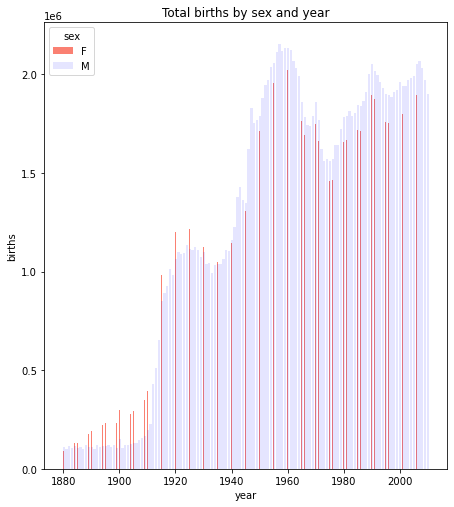

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(1,figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.subplots_adjust(top=0.9,left=0.2)
ax1.set_ylabel('births')

ax1.set_xlabel('year')
width=.1
ax1.bar(total_births.index,total_births['F'],color='salmon',label='F',width=width)
ax1.bar(total_births.index+width,total_births['M'],color='blue',label='M',alpha=.1)
ax1.set_title('Total births by sex and year')
    
ax1.legend(loc='upper left',title='sex')
plt.show()

#### Cross tab vs pivot table revisited

When do we do use a pivot table, when cross-tabulation?

The answer is that we use cross-tabulation whenever counting is involved, even normalized counting (percentages).

Recall the problem we solved with cross-tabulation in Part One of the Pandas Intro,
getting the joint distribution of complaint types and agencies:

In [11]:
import os.path
#How to break up long strings into multiline segments
#Note the use of "line continued" character \
data_url = 'https://raw.githubusercontent.com/gawron/python-for-social-science/master/'\
'pandas/datasets/311-service-requests.csv'
# Some columns are of mixed types.  This is OK.  But we have to set 
# low_memory=False
complaints = pd.read_csv(data_url,low_memory=False)
three = ['DOT', "DOP", 'NYPD']
pt00 = complaints[complaints.Agency.isin(three)]
# only show the first 15 of many rows
pd.crosstab(pt00['Complaint Type'], pt00['Agency']).iloc[:15]

Agency,DOP,DOT,NYPD
Complaint Type,,,
Agency Issues,0,20,0
Animal Abuse,0,0,164
Bike Rack Condition,0,7,0
Bike/Roller/Skate Chronic,0,0,32
Blocked Driveway,0,0,4590
Bridge Condition,0,20,0
Broken Muni Meter,0,2070,0
Bus Stop Shelter Placement,0,14,0
Compliment,0,1,0


In thinking about how we used `pd.crosstab` to solve this problem, it's worth considering
whether we could do this with a pivot table.

Pivot_table construction begins
the same way cross-tabulation does: it splits the rows into
groups such that each group contains all the
rows for one agency/compliant type say, 'NYPD'/'Anmal Abuse';
it then applies the aggregation function to each group.

There is an aggregation function`'count'` which does we want.
It simply computes the number of rows in each group.  

There is one wrinkle, and this
is the awkward part: the pivot table function needs an argument
for the `values` column (in other aggregation operations
this argument gives the numerical values to which the aggregation operation applies).  When the aggregation operation is `'count'` **any** valid column will serve.  

So we pick one at random, say `"Status"`.  The result is almost exactly
what we computed with `crosstab`, though with slightly
more obscure code:

In [12]:
three = ['DOT', "DOP", 'NYPD']
pt00 = complaints[complaints.Agency.isin(three)]
pt0 = pt00.pivot_table(values='Status', index='Complaint Type' , 
                       columns = 'Agency', aggfunc='count')
pt0.iloc[:15]                   

Agency,DOP,DOT,NYPD
Complaint Type,,,
Agency Issues,NaN,20.0,NaN
Animal Abuse,NaN,NaN,164.0
Bike Rack Condition,NaN,7.0,NaN
Bike/Roller/Skate Chronic,NaN,NaN,32.0
Blocked Driveway,NaN,NaN,4590.0
Bridge Condition,NaN,20.0,NaN
Broken Muni Meter,NaN,2070.0,NaN
Bus Stop Shelter Placement,NaN,14.0,NaN
Compliment,NaN,1.0,NaN


The difference is the appearance of `NaN` in all those places
where there were no rows in the group to count.

All in all, it is an improvement in clarity and informativeness to use crosstab for
this task.  As we shall see below, there are cases where cross tabulation
can be extended, using other aggregation operations, to build
DataFrames that are more easily understood as pivot_tables. The rule
of thumb is to use cross tabulation where the operation
applied to groups is counting.

Summarizing: this is the kind of problem to use cross-tabulation for.  It
involves counting.  

Even though it is possible to we call the `.pivot_table()` method on `complaints`,
using  `'count'` as the aggregation operation, this is not best practice
when counting is involved.

## Using pivot instead of groupby

As we discussed in part one, splitting (or grouping) is the first of the three operations in the split/apply/combine strategy.

We used the nba  dataset to illustrate, because it has some very natural
groupings.

We reload the NBA dataset.

In [3]:
import pandas as pd
nba_file_url = 'https://gawron.sdsu.edu/python_for_ss/course_core/data/nba.csv'
nba_df = pd.read_csv(nba_file_url)

Some of the questions we answered there could have been done with a pivot table:

For example, let's use a pivot table to answer the question about average weight of centers.

In [4]:
nba_pt_wt = nba_df.pivot_table('Weight','Position')
print(nba_pt_wt)
print()
print(f"And the answer is: {nba_pt_wt.loc['C','Weight']:.1f}")

              Weight
Position            
C         254.205128
PF        240.430000
PG        189.478261
SF        221.776471
SG        206.686275

And the answer is: 254.2


The numbers here are means because mean is the default aggregation function.  Similarly, consider the question:

What position  earns the highest salary on average?

The pivot table answer, going all the way to the highest valued position:

In [7]:
# Get pivot table; sort values for the Salary column, get first element of index
nba_df.pivot_table('Salary','Position')['Salary'].sort_values(ascending=False).index[0]

'C'

The point is that `pivot_table`, like `pd.crosstab`, executes the split-apply-combine
strategy in one step and so it will often be more convenient to call `pivot_table`
rather than `groupby`.

The `.groupby()` method is the first step in creating a pivot table; hence, we can always emulate
the effect of `.pivot_table()` by grouping and then apply an aggregation function.

However, if we're after
only one aggregation operation for a particular grouping, there really isn't an advantage to using `groupby`. 
We may as well use `pivot_table`.

### New Stocks dataset:  More pivot table examples using Time

1.  Adding columns to enable new kinds of grouping.
2.  "Melting" different value columns into 1 value column (in order to set up a pivot).
3.  Centering and scaling data.

In [30]:
import pandas as pd
import os.path
import urllib.request 
import os.path
from matplotlib import pyplot as plt

url_dir = 'https://gawron.sdsu.edu/python_for_ss/course_core/data'
time1 = pd.read_csv(os.path.join(url_dir,'stocks.csv'))
time1

,Unnamed: 0,date,AA,GE,IBM,MSFT
0,0,1990-02-01 00:00:00,4.98,2.87,16.79,0.51
1,1,1990-02-02 00:00:00,5.04,2.87,16.89,0.51
2,2,1990-02-05 00:00:00,5.07,2.87,17.32,0.51
3,3,1990-02-06 00:00:00,5.01,2.88,17.56,0.51
4,4,1990-02-07 00:00:00,5.04,2.91,17.93,0.51
...,...,...,...,...,...,...
5467,5467,2011-10-10 00:00:00,10.09,16.14,186.62,26.94
5468,5468,2011-10-11 00:00:00,10.30,16.14,185.00,27.00
5469,5469,2011-10-12 00:00:00,10.05,16.40,186.12,26.96
5470,5470,2011-10-13 00:00:00,10.10,16.22,186.82,27.18


To get the idea of this data set try this:

**Plotting challenge**:  Plot IBM and GE stock prices for February.  Try to place the two plots
side by side.

Note: even though the values in the `'date'` column are strings, they've very well chosen strings
for our purposes.  Normal string sorting will reproduce chronological order.

There are no NaN  values in the data.

In [721]:
len(time1), len(time1.dropna())

(5472, 5472)

Now to get the data for a month we **could** do our grouping by hand, as in the following cell,
which zooms in on February.

In [651]:
time_feb = time1[(time1['date'] >='1990-02-01 00:00:00') & (time1['date'] < '1990-03-01 00:00:00') ]

But DataFrames with a time series index provide certain time-specfic services that will make this
much easier.

So let's promote our `'date'` column to be the index to take advantage of those.  We first construct
a `pandas`-specific kind of Index called a `DatetimeIndex` using the dates in the `'date'` column, then 
set that to be our index.

In [132]:
time2 = time1.set_index(pd.DatetimeIndex(time1['date']))

In [133]:
time2[:6]

,Unnamed: 0,date,AA,GE,IBM,MSFT
date,,,,,,
1990-02-01,0,1990-02-01 00:00:00,4.98,2.87,16.79,0.51
1990-02-02,1,1990-02-02 00:00:00,5.04,2.87,16.89,0.51
1990-02-05,2,1990-02-05 00:00:00,5.07,2.87,17.32,0.51
1990-02-06,3,1990-02-06 00:00:00,5.01,2.88,17.56,0.51
1990-02-07,4,1990-02-07 00:00:00,5.04,2.91,17.93,0.51
1990-02-08,5,1990-02-08 00:00:00,5.04,2.92,17.86,0.51


The objects in our new index are Pandas Timestamp objects, which are inspired by and very closely related to
Python's DateTime objects (imported with the `datetime` module).  They represent moments in time defined
by a specific date and time.  The month, year, hour, minute, and second of a `TimeStamp` instance can all
be retrieved with methods of the same name:

In [107]:
# TimeStamp instance 
dt = time2.index[0]
print(dt, type(dt))
print('Month  ',dt.month)
print('Hour   ', dt.hour)
print('Day    ', dt.day)
# Feb 1 1990 was on a Thursday (0-based indexing, Monday is first day)
print('Weekday', dt.weekday())
# Print it out nice using format codes from datetime module
print(dt.strftime('%a %b %d %Y %H:%M:%S'))


1990-02-01 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Month   2
Hour    0
Day     1
Weekday 3
Thu Feb 01 1990 00:00:00


As with columns contained strings, `pandas` supplies vectorized operations on any
`DateTimeIndex`.

In [134]:
# We get the year of every timestamp instance in the index
time2.index.year

Int64Index([1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990,
            ...
            2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011],
           dtype='int64', name='date', length=5472)

Note with string columns we needed to use the `.str` method before invoking a vectorized string method.
That is unnecessary in this instance, but only because we are dealing with a `DateTimeIndex`.

If we create a `Series` instance containing `TimeStamp` instances,  then an analogue of `str` is required.
The analogue of `str` is `dt`.

In [111]:
# A Series containing TimeStamp instances
new_date = pd.to_datetime(time1['date'])

In [115]:
try:
    new_date.year
except AttributeError as e:
    print('new_date.year raises an Exception:', e,sep='\n  ')
print()
print('new_date.dt.year:', new_date.dt.year,sep='\n')

new_date.year raises an Exception:
  'Series' object has no attribute 'year'

new_date.dt.year:
0       1990
1       1990
2       1990
3       1990
4       1990
        ... 
5467    2011
5468    2011
5469    2011
5470    2011
5471    2011
Name: date, Length: 5472, dtype: int64


Using this DateTimeIndex, we  can segregate all the days that belong to a given month 
or given year or both.  We illustrate

In [59]:
feb1992 = time2[(time2.index.month == 2) & (time2.index.year == 1992)]

Day by day plot for Feb 1992 for two different stocks.

<AxesSubplot:xlabel='date'>

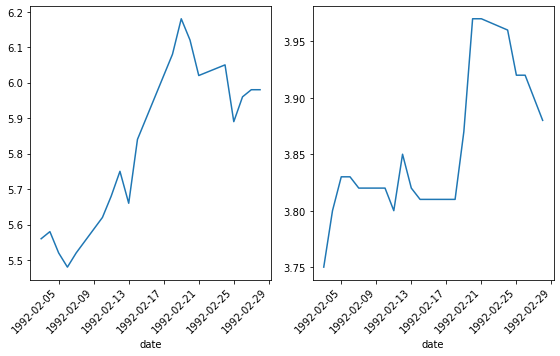

In [60]:
# Subplot array is 1x2 1 row with 2 cols.
(fig, (ax1,ax2))  = plt.subplots(1,2,figsize=(8,5))
# More room between subplots
fig.tight_layout()
# Rotate the xaxis labels 45 degrees to get them to display nicer.
feb1992['AA'].plot(rot=45,ax=ax1)
feb1992['GE'].plot(rot=45,ax=ax2)

One important motivation for making the TimeStamp sequence the Index rather than a column is
that it opens the door to temporally based grouping, which is a very common move
with Time Series data.

The `resample` method on DataFrames
is basically a `group_by` operation in which the groups are defined by some temporal property.
It requires the Index to be temporal series of some sort.

In [24]:
month_groups=time2.resample('M')

Here we have grouped by month.

Month groups are referenced by the last day of each month group.

In [150]:
month_groups.get_group('1990-02-28')[:5]

,Unnamed: 0,date,AA,GE,IBM,MSFT
date,,,,,,
1990-02-01,0,1990-02-01 00:00:00,4.98,2.87,16.79,0.51
1990-02-02,1,1990-02-02 00:00:00,5.04,2.87,16.89,0.51
1990-02-05,2,1990-02-05 00:00:00,5.07,2.87,17.32,0.51
1990-02-06,3,1990-02-06 00:00:00,5.01,2.88,17.56,0.51
1990-02-07,4,1990-02-07 00:00:00,5.04,2.91,17.93,0.51


Now it is very easy to get the means for each month, and works 
much the same as getting means for `groupby` instances.

In [41]:
#This is a DataFrame
mean_by_months = month_groups.mean()

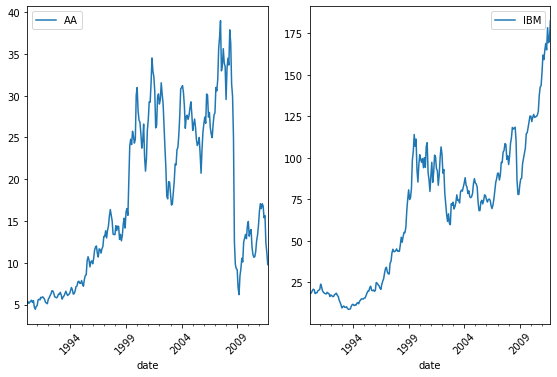

In [120]:
# Subplot array is 1x2 1 row with 2 cols.
(fig, (ax1,ax2))  = plt.subplots(1,2,figsize=(8,5))
# More room between subplots
fig.tight_layout()
# Rotate the xaxis labels 45 degrees to get them to display nicer.
mean_by_months['AA'].plot(rot=45,ax=ax1)
ax1.legend()
mean_by_months['IBM'].plot(rot=45,ax=ax2)
ax2.legend()

**What stock gave the best return over the  time period in the data?**

To answer this question we essentially want to perform a **delta calculation**: subtract the value on the first day from the value on the last day.  The issue is what measure of value should we use when stock share prices differ significantly in scale  (compare IBM
and AA in Feb 1990 in the plot above).  We need some way of scaling the price differences so
as to make them comparable.

We will present one way of doing this without a great deal of discussion because this question is essentially a pretext for showing you how to **center** and **scale** data.

Strategy:  Center and scale each stock column to show stock price in standard deviation units.
(Plot the three resulting stock price lines, for fun).  **Delta calculation**:  For each stock, compute the difference between the first and last days in the data in  standard deviation units.

The stock that is the furthest above its starting point at the end of the period is the winner.  Note that the "center" of the centering is arbitrary for this calculation.  We choose to make it the mean because that is a standard choice. But in the end we're just computing the difference in values beween the last day and the first day, and the choice of center will have no effect on that difference.

```
(x_last - c) - (x_first - c) = x_last - x_first
```

What does matter is the choice of the units we use to represent stock values.  We choose
`standard deviation units` because that is a reasonable way to standardize the prices of stocks.

The next cell actually centers and scales each column.  

In [151]:
df = mean_by_months[['AA','GE','IBM','MSFT']]
mn,std = df.mean(),df.std()
# centering (the numerator)  & scaling (the denominator)
new_df=(df-mn)/std

How did **that** work?  Well, `pandas` sensibly decides
that in a normally structured DataFrame, it doesn't make sense to take
the mean or standard deviation of a row  (each column is a different kind of thing),
so mean and standard deviation calculations are automatically applied to columns.

In [152]:
mn

AA      17.445346
GE      17.947286
IBM     66.919186
MSFT    17.080430
dtype: float64

When we subtract this from `df` the numbers are automatically aligned with columns, and 

```
df - mn
```

automatically turns into elementwise subtraction of the mean from each column.

Note that for the cell above to work we should (minimally) have a DataFrame with
all numerical columns and no NaN issues (or at least NaN issues that have
been thought through in advance).  Our pivot table meets these criteria: It is all numerical with no NaNs.
Because there are no NaNs in the original DataFrame `time1`, we could have
just as easily have used the three value columns in `time1` for centering and scaling,
but we would end up with a DataFrame with no temporal index and no time related columns.

Here is the result of centering the mean by months DataFrame:

In [153]:
new_df

,AA,GE,IBM,MSFT
date,,,,
1990-02-28,-1.288710,-1.418216,-1.172091,-1.508003
1990-03-31,-1.255604,-1.409703,-1.155745,-1.501460
1990-04-30,-1.278598,-1.402754,-1.148573,-1.497498
1990-05-31,-1.264343,-1.391229,-1.116268,-1.489040
1990-06-30,-1.251783,-1.380342,-1.096900,-1.480837
...,...,...,...,...
2011-06-30,-0.213580,0.032714,2.336573,0.657461
2011-07-31,-0.186770,0.052048,2.654514,0.885148
2011-08-31,-0.529118,-0.194660,2.439593,0.750245


<AxesSubplot:xlabel='date'>

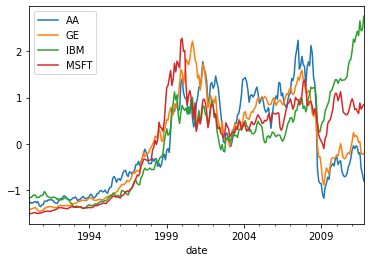

In [129]:
new_df.plot()

**Delta calculation**: The winner, as the picture suggests, is IBM.

In [130]:
# (Values on last day) - (Values on first day)
(new_df.iloc[-1] - new_df.iloc[0])

AA      0.491963
GE      1.210078
IBM     3.926800
MSFT    2.354078
dtype: float64

Of course it always matters what time period you choose: Same steps as above over different time period.

Different answer for what the best stock is and different evaluation of IBM.

In [140]:
time3 = time2[time2.index.year < 2008][['AA','GE','IBM','MSFT']]
month_groups3=time3.resample('M')
df3 = month_groups3.mean()
mn3,std3 = df3.mean(),df3.std()
# centering (the numerator)  & scaling (the denominator)
new_df3=(df3-mn3)/std3

Revised plot.

<AxesSubplot:xlabel='date'>

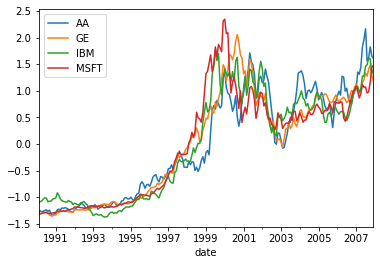

In [141]:
new_df3.plot()

Revised delta calculation (IBM in last place!):

In [143]:
(new_df3.iloc[-1] - new_df3.iloc[0]).sort_values(ascending=False)

AA      2.892419
MSFT    2.792529
GE      2.507379
IBM     2.496016
dtype: float64

## Introducing Merging

In this section we introduce `pandas` merging function, which merges the data
in two different DataFrames into one DataFrame.  

We will look at an example that illustrates the simplest case, the
case where the indexes of the two DatFrames agree.
The operation is very much like the following operation in
`numpy`:

In [74]:
import numpy as np
## Prepare a1
a1 = np.ones((3,4))
a1[1] =np.zeros(4,)
print(a1)
## Prepare a2
a2 = np.zeros((3,5))
a2[1] = np.ones((5,))
print(a2)
# Merge
np.concatenate([a1,a2],axis=1)

[[1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]]
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]


array([[1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0.]])

We concatenate the rows of the first array with the row sof the second, ending up with 
a new array with 9 columns.

The pandas merge operation will be very
similar, except that in pandas merging, the order of the rows won't matter.  The indexes of the
two DataFrames are used to align the rows.

We begin by loading the first of our two DataFrames, which contains LifeSatisfaction data
on many countries.

In [14]:
import pandas as pd
import importlib.util
import os.path
#from google.colab import drive

notebook_lifesat_url0 = 'https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/'
oecd_file = 'oecd_bli_2015.csv'
oecd_url= f'{notebook_lifesat_url0}{oecd_file}'
# Clean up some number formatting issues '1,000' => 1000
# Unicode characters that can only be interpreted with an encoding
oecd_bli = pd.read_csv(oecd_url, thousands=',',encoding='utf-8')
# Focus on a subset of of the daty
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]

This table contains economic and social statistics for people in a number of countries.  The `INEQUALITY` attribute contains statistics for subpopulations like low/high income, men/women.  Since we won't be looking at those sub-populations in this section, the first step after reading in the data is to reduce the table to those 
rows containing statistics about the total population.

The data in this big table is stored in an interesting and very popular format. Let's understand that 
before moving on.  First there are facts about 36 distinct countries.  One of the names in the `Country`
column  (`OECD - Total`) is a label under which totals for all the countries will be aggregated.

In [17]:
countries = oecd_bli['Country'].unique()
print(f'{len(countries)} countries in data')
print (countries)

37 countries in data
['Australia' 'Austria' 'Belgium' 'Canada' 'Czech Republic' 'Denmark'
 'Finland' 'France' 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland'
 'Italy' 'Japan' 'Korea' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand'
 'Norway' 'Poland' 'Portugal' 'Slovak Republic' 'Spain' 'Sweden'
 'Switzerland' 'Turkey' 'United Kingdom' 'United States' 'Brazil' 'Chile'
 'Estonia' 'Israel' 'Russia' 'Slovenia' 'OECD - Total']


The cell below shows what happens when we zoom in on one country, Poland.  The table contains a number of rows with information about Poland, each with a different value in the  `Indicator` column.  That is the name of some statistic about Poland.  The numerical value for that statistic is in the `Value` column and the unit for that statistic and the unit is in the `UNIT CODE` (or `Unit`) column.  So the first row printed out tells us that 3.2% of all households in Poland are dwellings without basic facilities, an indicator of substantial poverty.

In [19]:
pol = oecd_bli[oecd_bli["Country"]=="Poland"]
pol.iloc[:,:12]


,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode
21,POL,Poland,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units
130,POL,Poland,HO_HISH,Housing expenditure,L,Value,TOT,Total,PC,Percentage,0,units
239,POL,Poland,HO_NUMR,Rooms per person,L,Value,TOT,Total,RATIO,Ratio,0,units
348,POL,Poland,IW_HADI,Household net adjusted disposable income,L,Value,TOT,Total,USD,US Dollar,0,units
531,POL,Poland,IW_HNFW,Household net financial wealth,L,Value,TOT,Total,USD,US Dollar,0,units
640,POL,Poland,JE_EMPL,Employment rate,L,Value,TOT,Total,PC,Percentage,0,units
825,POL,Poland,JE_JT,Job security,L,Value,TOT,Total,PC,Percentage,0,units
936,POL,Poland,JE_LTUR,Long-term unemployment rate,L,Value,TOT,Total,PC,Percentage,0,units
1121,POL,Poland,JE_PEARN,Personal earnings,L,Value,TOT,Total,USD,US Dollar,0,units
1306,POL,Poland,SC_SNTWS,Quality of support network,L,Value,TOT,Total,PC,Percentage,0,units


We can use the `pivot` method to recast the data into a much easier to grasp format.  The key point is that each country and INDICATOR determines a specific value.  So let's have one row for each country with one column for each `INDICATOR`, and in that column we'll place the `VALUE` associated with that country and that indicator.  It's as easy as this:

In [53]:
oecd_bli_pt = oecd_bli.pivot_table(index="Country", columns="Indicator", values="Value")
# Looking at one row
oecd_bli_pt.loc['Poland']

Indicator
Air pollution                                   33.00
Assault rate                                     1.40
Consultation on rule-making                     10.80
Dwellings without basic facilities               3.20
Educational attainment                          90.00
Employees working very long hours                7.41
Employment rate                                 60.00
Homicide rate                                    0.90
Household net adjusted disposable income     17852.00
Household net financial wealth               10919.00
Housing expenditure                             21.00
Job security                                     7.30
Life expectancy                                 76.90
Life satisfaction                                5.80
Long-term unemployment rate                      3.77
Personal earnings                            22655.00
Quality of support network                      91.00
Rooms per person                                 1.10
Self-reported heal

Looking back to compare one value in the original DF, with the derived data in the pivot:

In [55]:
poland = oecd_bli[oecd_bli['Country']=='Poland']
poland[poland['Indicator']  == 'Job security']['Value']

825    7.3
Name: Value, dtype: float64

In [56]:
oecd_bli_pt.loc['Poland'].loc['Job security']

7.3

What is weird about what we just did with `pivot_table`?

The example above is not an outlier.  For every country/indicator pair, the value in the `'Value'` column 
in the original DataFrame is
exactly the same as the value in the corresponding row and column of the pivot table.
It appears as if no aggregation operation has taken place!

Actually appearances are deceiving.  What has happened is that in this particular data set
all the row groups we get by pairing country and indicator are of size 1; the default
aggregation operation is mean and when we take the mean of a single number we get that number back.

So what is the point of creating a pivot table then?  The point is that we've
restructured the data into a more comprehensible  
(and more easily manipulated) format;  and that is one of
the most important uses of the pivot table operation.  Sometimes we want to collapse
multiple rows into one just because the data is easier to work with that way.
Compare the original DataFrame with the pivot table and see if you don't 
agree that this data set is a case in point.

## A column of particular interest

In future exercises with this data, we're going to take particular interest in the `Life satisfaction` score,  a kind of general "quality of life" or "happiness" score computed from a formula combining the indicators in this data. 

That is, it is a value computed from the other values in the same row.  In a regression
context, we would think of this as the dependent variable, the variable whose value
we try to compute as some function of the others.

In [58]:
oecd_bli_pt["Life satisfaction"].head()

Country
Australia    7.3
Austria      6.9
Belgium      6.9
Brazil       7.0
Canada       7.3
Name: Life satisfaction, dtype: float64

# Load and prepare GDP per capita data

Elsewhere, on the world wide web, with help from Google, we find data about GDP  ("gross domestic product")
[here](http://goo.gl/j1MSKe).

This is the second of the two DatFrames we will merge.

This is a very simple data frame with columns containing various
useful country-specific pieces of information.  Since there is one row per
country, we have made the `'Country`' column the index.

In [59]:

# Downloaded data from http://goo.gl/j1MSKe (=> imf.org) to github
gdp_file = "gdp_per_capita.csv"
gdp_url = f'{notebook_lifesat_url0}{gdp_file}'
gdp_per_capita = pd.read_csv(gdp_url, thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
# Make "Country" the index column.  We are going to merge data on this column.
gdp_per_capita.set_index("Country", inplace=True)
#gdp_per_capita.head(2)
gdp_per_capita.index

Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       ...
       'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe', 'International Monetary Fund, World Economic Outlook Database, April 2016'], dtype='object', name='Country', length=190)

Note that this lines up reasonably well with the index of the pivot table we created above.

In [19]:
oecd_bli_pt.index

Index(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Korea', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway',
       'OECD - Total', 'Poland', 'Portugal', 'Russia', 'Slovak Republic',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'United Kingdom', 'United States'],
      dtype='object', name='Country')

 We now engage in the great magic, the single most important operation by which information is created, the `merge`.
 We are going to take the quality of life data, which is indexed by country, and the GDP data, now also indexed
 by country, and  merge rows, producing one large table which contains all the rows and columns of the `oecd_bli` table,
 as well as a new `GDP per Capita` column.

In [78]:
full_country_stats = pd.merge(left=oecd_bli_pt, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace=True)
len(oecd_bli_pt),len(gdp_per_capita),len(full_country_stats)

(37, 190, 36)

Note that the gdp data cotained many rows not contained in the life satisfaction data index.  Those rows were
ignored.

We have a new DataFrame combining the columns of the two merged DataFrames:

In [79]:
print(len(oecd_bli_pt.columns),len(gdp_per_capita.columns),len(full_country_stats.columns))
full_country_stats.head(2)

24 6 30


,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,21.0,4.6,73.7,7.0,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",8669.998,2014.0
Mexico,30.0,12.8,9.0,4.2,37.0,28.83,61.0,23.4,13085.0,9056.0,21.0,4.9,74.6,6.7,0.08,16193.0,77.0,1.0,66.0,417.0,13.89,63.0,67.0,14.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9009.280,2015.0


We print out a sub DataFrame containing just the GDP per capita and Life Satisfaction columns;
we look at the `"United States"` and following rows:


In [75]:
full_country_stats[["GDP per capita", 'Life satisfaction']].loc["United States":]

,GDP per capita,Life satisfaction
Country,,
United States,55805.204,7.2
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


In a future exercise we will try to run a linear regression analysis to predict Life Satisfaction.

As a first step, it might be interesting to see how well we could do just using GDP, though
a close look at the rows above shows no linear predictor will be perfect:  An increase
in GDP does not necessarily predict an increase in life satisfaction.

Summing up what we did in this section.  We loaded two Data frames and merged them on their
indexes, in effect concatenating the rows of the first dataFrame with the rows of the second.

In order to execute the merge we had to make sure their indexes contained
the same sort of things.  We modified he first dataset with a pivot table operation
that made `'Countries'` the index.  We modified the second dataset by promoting
the `'Countries'` column to be the index.

### Another kind of merging: Join

We look at a second Merge example involving a slightly different operation `join`. 

We will merge data about U.S. Covid case numbers with geographical data,
to allow visualizing the data on maps.

In [108]:
import pandas as pd
from datetime import datetime


def geoid2code(geoid):
    return int(geoid[4:])

# this data set has cumulative stats
nyt_github_covid_cumulative = 'https://raw.githubusercontent.com/nytimes/'\
                        'covid-19-data/master/us-counties.csv'
nyt_github_covid_rolling_avg = 'https://raw.githubusercontent.com/nytimes/'\
                        'covid-19-data/master/rolling-averages/us-counties.csv'
df = pd.read_csv(nyt_github_covid_rolling_avg,converters=dict(geoid=geoid2code))
#df.rename(columns={'geoid': 'GEOID'},inplace=True)

start, end = datetime.fromisoformat(df['date'].min()),\
               datetime.fromisoformat(df['date'].max())

One row per county day pair containing various kind of Covide case data.

In [110]:
df2 = df[(df['county']=='Cook') & (df['state']=='Illinois')]
df2

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
4,2020-01-24,17031,Cook,Illinois,1,0.14,0.00,0,0.00,0.00
6,2020-01-25,17031,Cook,Illinois,0,0.14,0.00,0,0.00,0.00
9,2020-01-26,17031,Cook,Illinois,0,0.14,0.00,0,0.00,0.00
14,2020-01-27,17031,Cook,Illinois,0,0.14,0.00,0,0.00,0.00
19,2020-01-28,17031,Cook,Illinois,0,0.14,0.00,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
1760590,2021-09-25,17031,Cook,Illinois,0,865.71,16.81,0,8.86,0.17
1763838,2021-09-26,17031,Cook,Illinois,0,865.71,16.81,0,8.86,0.17
1767086,2021-09-27,17031,Cook,Illinois,1924,786.86,15.28,21,8.57,0.17
1770334,2021-09-28,17031,Cook,Illinois,486,748.00,14.52,17,10.29,0.20


### Adding Lat Longs to the data

The Geographical info is stored in a column named `'geoid'` (note the lower case).

In [111]:
df[:5]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,2020-01-24,17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0


The `'geoid'` column contains FIPS geographical codes that we can use to make maps
visualizing the geographic distribution of the Covid data.

The problem is many of the  programs designed for that purpose want 
lat/long coordinates.

Solution: we go to the **census.gov** site to find mappings from geocodes
to lat/longs.  We turn this new data into a pandas DataFrame.  We then **join**
the new DataFrame to our old one.

In [93]:
#Normally you'd get this data at census.giv from a compressed file.
true_url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2021_Gazetteer/'\
      '2021_Gaz_counties_national.zip'
# To simplify things Ive uncompressed it and copied it here, uncompressed,
url = 'https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/'\
      '202### Doing the join1_Gaz_counties_national.txt'
# The file uses tabs, not "," as a separator.  `pd.read_csv` still works if you 
# tell it that.
codes = pd.read_csv(url,sep='\t')
# last column name misparsed, many spaces added.  data cleanup
long = codes.columns[-1]
codes.rename(columns={long: long.strip()},inplace=True)


Note that the new data set has both a GEOID column and LAT and LONG columns; note the case of 'GEOID'.

In fact, the LAT/LONGs are located at the centers of the GEOID regions,
so each GEOID value is associated with exactly one LAT/LONG pair.

In [92]:
codes[:5]

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,1001,161526,Autauga County,1539634184,25674812,594.456,9.913,32.532237,-86.646440
1,AL,1003,161527,Baldwin County,4117656514,1132955729,1589.836,437.437,30.659218,-87.746067
2,AL,1005,161528,Barbour County,2292160149,50523213,885.008,19.507,31.870253,-85.405104
3,AL,1007,161529,Bibb County,1612188717,9572303,622.470,3.696,33.015893,-87.127148
4,AL,1009,161530,Blount County,1670259090,14860281,644.891,5.738,33.977358,-86.566440


In addition, each county has a unique GEOID.

In [91]:
codes[(codes['NAME']=='King County')&(codes['USPS']=='WA')]

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
2970,WA,53033,1531933,King County,5479337396,496938967,2115.584,191.869,47.490552,-121.833977


Going back from the GEOID gets us the same row.

In [90]:
codes[(codes['GEOID']==53033)]

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
2970,WA,53033,1531933,King County,5479337396,496938967,2115.584,191.869,47.490552,-121.833977


### Doing the join

In this section we explain the  **join** operation that we'll use to merge
the lat-long info in the codes table with the Covid data.

The idea is to join on GEOID.  Since each GEOID identifies a unique LAT/LONG pair, let's
zero in on just the columns we want to merge into the Covid data.

In [107]:
#Make the subtable we're going to join to.
geoid_lat_long = codes[['GEOID','INTPTLAT','INTPTLONG']]
geoid_lat_long[:5]

,GEOID,INTPTLAT,INTPTLONG
0,1001,32.532237,-86.646440
1,1003,30.659218,-87.746067
2,1005,31.870253,-85.405104
3,1007,33.015893,-87.127148
4,1009,33.977358,-86.566440


We promote the GEOID column to be an index.

In [103]:
geoid_lat_long_gind = geoid_lat_long.set_index('GEOID')
geoid_lat_long_gind[:5]

,INTPTLAT,INTPTLONG
GEOID,,
1001,32.532237,-86.646440
1003,30.659218,-87.746067
1005,31.870253,-85.405104
1007,33.015893,-87.127148
1009,33.977358,-86.566440


Let's prepare some test rows we'll check to see the join goes right.

Here are some rows from the Covid data that all share their GEOID (because they contain data for the same county on different days).  After the join, we'd like all these
rows linked to the same Lat/Long info.

In [112]:
df[:4]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0


Here we do the join, and we see it has the desired effect.

The new DataFrame has two new LAT/LONG columns. Rows with the same GEOID value have the same LAT/LONG
values.

In [113]:
new_df = df.join(geoid_lat_long_gind,on='geoid')
new_df[:4]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,INTPTLAT,INTPTLONG
0,2020-01-21,53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
1,2020-01-22,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
2,2020-01-23,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
3,2020-01-24,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038


Let's summarize what we did.

1.   We had two columns (`INTPTLAT`,`INTPTLONG`) in the join DataFrame (`geoid_lat_long_gind`) that we wanted to distribute to the rows of the Covid df (`df`). 
2.  We identified a column in `df` that we were going to merge **on** (`'geoid'`).  This column is like an indexing column in a pivot or cross-tabulation.   It divides the rows of `df` into groups. Each group
should get the same `INTPTLAT`, `INTPTLONG` values.
3.  We promoted the geoid column in `geoid_lat_long_gind` to be the index.  Note the name of this promoted column
didn't matter (`'geoid'` and `'GEOID'` are different).  What mattered is that both `'geoid'` and `'GEOID'` contained the same value set, geoid codes.
4.  We did the join, creating a new data frame with the same number of rows as `df`, but two new columns. 

In [115]:
len(df),len(new_df),len(df.columns),len(new_df.columns)

(1774204, 1774204, 10, 12)

We join one DataFrame `df` with another `join` DataFrame.

What makes a join different from a merge is that there has to be a column in `df` that is joined **on**;
and the values in that column can all be found in the index of the join DataFrame.

The data in the join DataFrame is then distributed to the rows of `df` according to the row groups
defined by the joined-on column.

We do not show it here, but it is possible to join on more than one column, just as it is possible to use more than one column for grouping in a cross-tabulation or a pivot table.


## Summary and conclusion 

In Part two of our introduction to `pandas` we focused on pivoting and merging.

Both these topics fall under the general heading of restructuring data.  Pivot tables
collapse multiple rows of the input dfata, often making it easier to understand; often,
but not always, that involves performing some aggregation operation on groups of rows.

Merging operations combine data from two DataFrames (often from two different data sources).
Merging results in DataFrame with a different number of columns than either of the inputs.
This counts as restructuring.  But where pivoting and cross tabulation are essentially
ways of computing staistical summaries, merging has the potential creating new information
and adding  value.  Adding GDP numbers to the life satisfaction data opened up new ways
of constructing a data model.  Adding lat longs to the Covid data opened the door to new
kinds of visualization.